In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
from sora import sora
from skimage.transform import resize
from PIL import Image

# Load and Process the Dataset

In [2]:
dataset = np.load("./thope-and-shomakh.npy")
processed_dataset = np.zeros((dataset.shape[0], 64, 64, 3))

for i in range(dataset.shape[0]):
    img = Image.fromarray(np.uint8(dataset[i]))
    img = img.resize((64, 64))
    processed_dataset[i] = np.array(img)

processed_dataset = processed_dataset / 255.0

# Building the GAN Model

## Config

In [3]:
latent_dim = 100
iterations = 1000000
batch_size = 64

image_shape = processed_dataset.shape[1:]

## Generator

In [4]:
gen_input = layers.Input(shape=(latent_dim, ))
gen = layers.Dense(32 * 32 * 128)(gen_input)
gen = layers.LeakyReLU()(gen)
gen = layers.Reshape((32, 32, 128))(gen)
gen = layers.UpSampling2D()(gen)
gen = layers.Conv2D(128, 4, padding='same')(gen)
gen = layers.BatchNormalization(momentum=0.8)(gen)
gen = layers.LeakyReLU()(gen)
gen = layers.Conv2D(64, 4, padding='same')(gen)
gen = layers.BatchNormalization(momentum=0.8)(gen)
gen = layers.LeakyReLU()(gen)
gen = layers.Conv2D(32, 4, padding='same')(gen)
gen = layers.BatchNormalization(momentum=0.8)(gen)
gen = layers.LeakyReLU()(gen)
gen = layers.Conv2D(3, 8, padding='same')(gen)
gen = layers.Activation('tanh')(gen)
gen = tf.keras.Model(gen_input, gen)
gen.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 131072)            13238272  
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 131072)            0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 128)       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 128)       262272    
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 128)       512       
__________

## Discriminator

In [5]:
dis_input = layers.Input(shape=image_shape)
dis = layers.Conv2D(128, kernel_size=3, padding='same')(dis_input)
dis = layers.LeakyReLU()(dis)
dis = layers.Conv2D(128, kernel_size=4, strides=2, padding='same')(dis)
dis = layers.LeakyReLU()(dis)
dis = layers.Conv2D(128, kernel_size=4, strides=2, padding='same')(dis)
dis = layers.LeakyReLU()(dis)
dis = layers.Conv2D(128, kernel_size=4, strides=2, padding='same')(dis)
dis = layers.LeakyReLU()(dis)
dis = layers.Flatten()(dis)
dis = layers.Dropout(0.25)(dis)
dis = layers.Dense(1, activation='sigmoid')(dis)
dis = tf.keras.Model(dis_input, dis)
dis.summary()

optimizer = tf.keras.optimizers.RMSprop(lr=0.0005, clipvalue=1.0, decay=1e-8)
dis.compile(optimizer, loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 128)       3584      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 128)       262272    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 128)       0         
__________

## GAN

In [6]:
dis.trainable = False
gan_input = layers.Input(shape=(latent_dim, ))
generated_image = gen(gan_input)
gan_output = dis(generated_image)
gan = tf.keras.Model(gan_input, gan_output)
gan.summary()

gan_optimizer = tf.keras.optimizers.RMSprop(lr=0.0005, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model (Model)                (None, 64, 64, 3)         13671523  
_________________________________________________________________
model_1 (Model)              (None, 1)                 798593    
Total params: 14,470,116
Trainable params: 13,671,075
Non-trainable params: 799,041
_________________________________________________________________


# Training

0, d_loss: 0.679314, gan_loss: 0.437173]



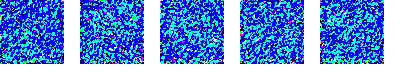

1000, d_loss: 0.601295, gan_loss: 0.983709]



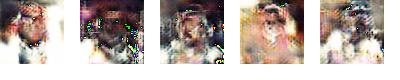

2000, d_loss: 0.563294, gan_loss: 1.314025]



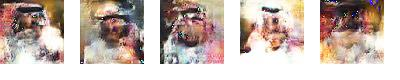

3000, d_loss: 0.515362, gan_loss: 0.934114]



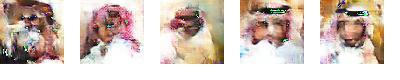

4000, d_loss: 0.391569, gan_loss: 2.550054]



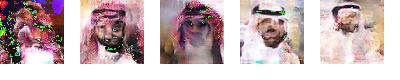

5000, d_loss: 0.281936, gan_loss: 1.827824]



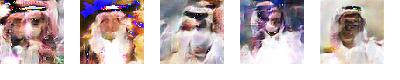

KeyboardInterrupt: 

In [7]:
real_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))

for i in range(iterations):
    random_indxs = np.random.randint(0, processed_dataset.shape[0], batch_size)
    real_images = processed_dataset[random_indxs]

    random_vectors = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_images = gen.predict(random_vectors)
    
    all_images = np.concatenate([real_images, fake_images])
    all_labels = np.concatenate([real_labels, fake_labels])
    all_labels += 0.05 * np.random.random(all_labels.shape)
    
    d_loss = dis.train_on_batch(all_images, all_labels)

    gan_loss = gan.train_on_batch(random_vectors, real_labels)

    if i % 1000 == 0:
        gan.save_weights('thopeGAN.h5')
        print ("%d, d_loss: %f, gan_loss: %f]" % (i, d_loss, gan_loss))
        sora(fake_images[0:5] * 255, cell_width=80, cell_height=80, items_per_row=5)